<a href="https://colab.research.google.com/github/abel-source/linear_vs_non-linear/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02.  Neural network classification with PyTorch

Classification is a prob;em of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [41]:
import sklearn

In [42]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [43]:
len(X), len(y)

(1000, 1000)

In [44]:
print(f"First 5 samples of X: \n{X[:5]}")
print("")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y: [1 1 1 1 0]


In [45]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)#Show the first 10 data

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


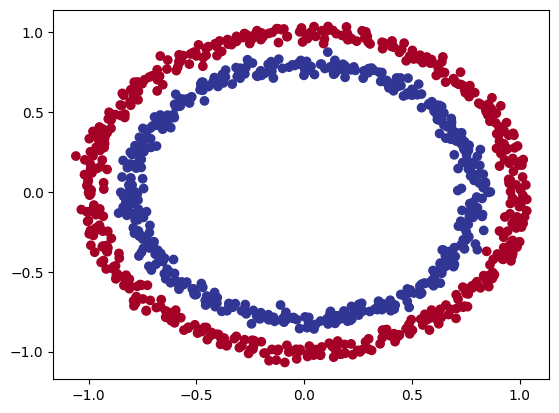

In [46]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [47]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn the data into tensors and create train and test splits

In [48]:
# Before converting the type
type(X), X.dtype, y.dtype

(numpy.ndarray, dtype('float64'), dtype('int64'))

In [49]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float32) # because the default type of numpy is float64 and the default for torch is float32
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [50]:
# After converting the type
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [51]:
# Split data into train and test sets using sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, #Percentage wise - 20% of the data is used for testing and the remaning for the tranining
                                                    train_size=0.8,
                                                    random_state=42,
                                                    )

In [52]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our ble and red dots.

To do so, we want to:

1. Setup device agonistic code(Gpu or cpu)
2. Construct a model(By subclassing nn.module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [53]:
import torch
from torch import nn

#Device agnostic code
device = "cuda"if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.module`
2.  Create 2 `nn.linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass
4. Instantiate an instanec of our model class and send it to the target `device`

In [54]:
# 1. Construct a model
class CircleModelv0(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    #2 . Create 2 nn.linear layers capable of handling the shapes of our data
    self.stack_layer = nn.Sequential(
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_shape),
    )

  # 3. Define forward() method
  def forward(self, x: torch.tensor)->torch.tensor:
    return self.stack_layer(x)

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelv0(input_shape=2,hidden_units=5, output_shape=1).to(device)
model_0

CircleModelv0(
  (stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [55]:
# Make predictions without training the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape of predictions: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"\nFirst 10 test labels: {y_test[:10]}")

Length of predictions: 200, Shape of predictions: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: tensor([[0.5401],
        [0.4450],
        [0.6126],
        [0.5203],
        [0.3318],
        [0.2759],
        [0.2306],
        [0.1903],
        [0.6243],
        [0.4355]])

First 10 test labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer


For example for regression you might want MAE(Mean absolute error) or MSE(Mean squared error)

For classification you might want to use binary cross entropy and categorical cross entropy

The loss function measures how *wrong* your model prediction are

And for optimizer, two of the most common and useful are SGD and Adam, however Pytorch has many built-in options.

* We are gonna use `torch.nn.BECWithLogitLoss()`
* For difference optimizers see `torch.optim`

In [56]:
# Setup loss function
# loss_fn = nn.BCELoss() # Requires inputs to have gone through the sigmoid activation fucntion prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # Has sigmoid activation function built-in, combines both sigmoid and BCELoss

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [57]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Train the model

To train our model, we're going to need to build a training loop with the following step

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimzier step

### 3.1 Going from raw logits -> prediction probablities -> prediction labels

our model outputs are going to be raw **logits**.

**Logis** is the raw, unnormalized output scores produced by a neural netowrk's final layer before applying an activation function like softmax.

We can convert these **logits** into **prediction probablities** by passing them to some kind of activation function (eg. sigmoid for binary classificaiton and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`-for outputs of softmax

For our prediction pribability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=2` (class 2)


In [58]:
### 3.2 Building a training and testing loop

epochs = 100

#To train using the available device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test =  X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))# logitss -> Pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train) # we passed y_logits because the fn expects raw logits becuase it's BCEWithLogits
  train_acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step (Gradient desscent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72075, Acc: 50.00% | Test Loss: 0.71488, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70321, Acc: 50.00% | Test Loss: 0.69975, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69741, Acc: 55.00% | Test Loss: 0.69506, Test Acc: 55.50%
Epoch: 30 | Loss: 0.69537, Acc: 51.50% | Test Loss: 0.69368, Test Acc: 55.50%
Epoch: 40 | Loss: 0.69454, Acc: 50.25% | Test Loss: 0.69334, Test Acc: 53.00%
Epoch: 50 | Loss: 0.69412, Acc: 50.50% | Test Loss: 0.69331, Test Acc: 51.50%
Epoch: 60 | Loss: 0.69386, Acc: 50.25% | Test Loss: 0.69339, Test Acc: 49.50%
Epoch: 70 | Loss: 0.69368, Acc: 49.88% | Test Loss: 0.69349, Test Acc: 51.50%
Epoch: 80 | Loss: 0.69354, Acc: 50.00% | Test Loss: 0.69361, Test Acc: 51.50%
Epoch: 90 | Loss: 0.69343, Acc: 49.50% | Test Loss: 0.69373, Test Acc: 54.00%


## 4. Make predicitions and evaluate the model

from metrics it looks like our model isn't learning anything..

So to inspect it let's make some predictions and make them visual

To do so, we;re going to import a function called `plot_decision_boundary()`

In [59]:
import requests
from pathlib import Path

# Download helper function form learn Pytorch repo if it's not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


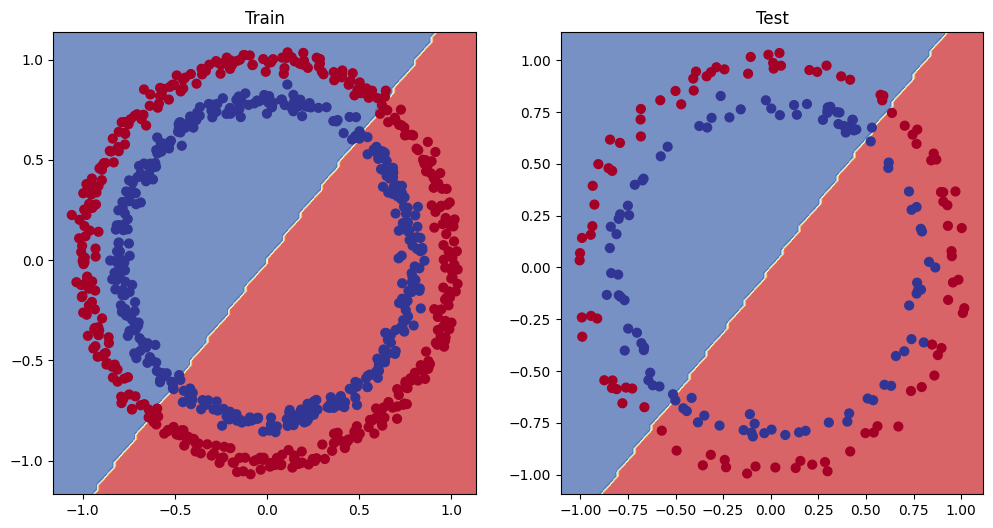

In [60]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. The missing piece: non-linearity

We can classify the model using non linear line

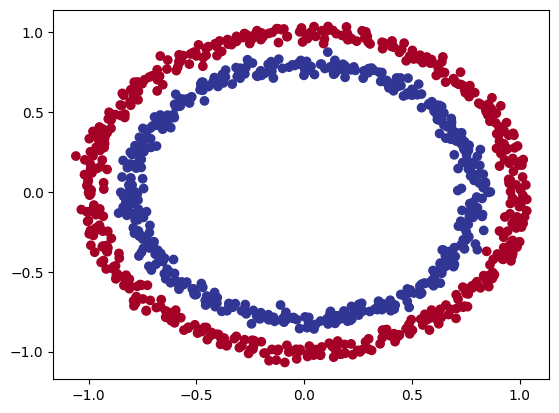

In [63]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [64]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 5.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = non-Straight line

In [65]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Max(0, x), non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelv2().to(device)
model_3

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [66]:
## setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr = 0.1)

In [67]:
X_train[:5], y_test[:5], device


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 1., 0., 1.]),
 'cpu')

In [70]:
# Training and testing we will do the same here

epochs = 1000

X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.12369, Acc: 99.88% | Test Loss: 0.16018, Test Acc: 99.50%
Epoch: 10 | Loss: 0.11796, Acc: 99.88% | Test Loss: 0.15412, Test Acc: 99.50%
Epoch: 20 | Loss: 0.11259, Acc: 99.88% | Test Loss: 0.14842, Test Acc: 99.50%
Epoch: 30 | Loss: 0.10756, Acc: 99.88% | Test Loss: 0.14312, Test Acc: 99.50%
Epoch: 40 | Loss: 0.10283, Acc: 99.88% | Test Loss: 0.13811, Test Acc: 99.50%
Epoch: 50 | Loss: 0.09839, Acc: 100.00% | Test Loss: 0.13334, Test Acc: 99.50%
Epoch: 60 | Loss: 0.09422, Acc: 100.00% | Test Loss: 0.12884, Test Acc: 100.00%
Epoch: 70 | Loss: 0.09031, Acc: 100.00% | Test Loss: 0.12460, Test Acc: 100.00%
Epoch: 80 | Loss: 0.08663, Acc: 100.00% | Test Loss: 0.12062, Test Acc: 100.00%
Epoch: 90 | Loss: 0.08317, Acc: 100.00% | Test Loss: 0.11683, Test Acc: 100.00%
Epoch: 100 | Loss: 0.07992, Acc: 100.00% | Test Loss: 0.11324, Test Acc: 100.00%
Epoch: 110 | Loss: 0.07686, Acc: 100.00% | Test Loss: 0.10983, Test Acc: 100.00%
Epoch: 120 | Loss: 0.07398, Acc: 100.00% | Test Lo

### 5.4 Evaluating a model trained with non-linear activation functions

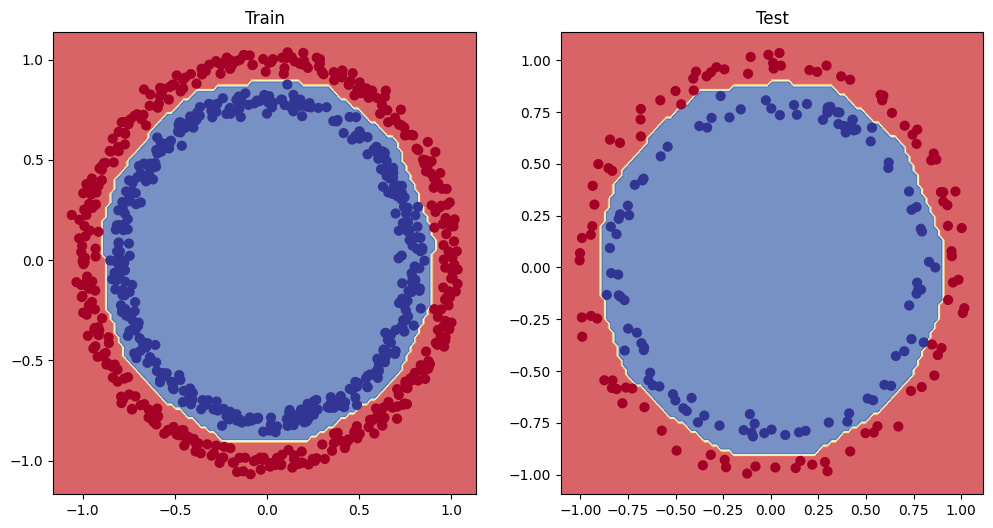

In [71]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)